# Pop Culture Clash: Do references help or hurt?

Milestone P2 initial analysis notebook exploring pop-culture references in the New Yorker Caption Contest data. The goal is to mirror our project sketch: build a keyword-based detector, compare referenced vs. non-referenced captions, and surface trends that will guide deeper modeling later in the term.

## Research questions
- Do captions that reference pop culture score higher on average than those that do not?
- Does recency matter—do very new references outperform older throwbacks?
- Are certain reference types more effective, and does that vary by image theme?
- Do pop-culture captions create more polarization than non-referential captions?
- Has the preference for pop-culture references changed over time?

## Notebook outline
1. Load caption contest summaries and lightweight metadata.
2. Tag captions with pop-culture references using the shared lexicon.
3. Normalize scores for caption length and contest effects.
4. Answer each research question with targeted tables and visuals.
5. Highlight yearly turning points where recency helps or hurts.

In [1]:
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm.auto import tqdm

import pop_culture_analysis as pca

plt.style.use('ggplot')
pd.options.display.max_rows = 10
pd.options.display.max_columns = 12
pd.options.display.float_format = '{:,.4f}'.format

tqdm.pandas()

In [2]:
captions = pca.load_caption_summaries()
print(f'{len(captions):,} captions across {captions['contest_id'].nunique()} contests')
captions.head()


2,297,153 captions across 385 contests


,rank,caption,mean,precision,votes,not_funny,somewhat_funny,funny,contest_id,method
0,0,I should have jumped from a higher floor.,1.9091,0.2506,11,4,4,3,510,RoundRobin
1,1,They told me it was a walk-on role.,1.8182,0.2264,11,4,5,2,510,RoundRobin
2,2,Guess I should have jumped from a few floors h...,1.8182,0.2635,11,5,3,3,510,RoundRobin
3,3,I was like you once.,1.8182,0.2635,11,5,3,3,510,RoundRobin
4,4,Not a care in the world...except stilettos.,1.8182,0.2264,11,4,5,2,510,RoundRobin


### Tag pop-culture references
We reuse the keyword lexicon from `analysis/pop_culture_analysis.py` to build a simple detector.

In [3]:
captions = captions.copy()
captions['caption'] = captions['caption'].astype(str)
meta = captions['caption'].progress_apply(pca.detect_pop_culture)
captions['pop_reference'] = meta.map(lambda x: int(x[0]))
captions['reference_labels'] = meta.map(lambda x: '|'.join(sorted(m.label for m in x[1])) if x[1] else None)
captions['reference_categories'] = meta.map(lambda x: '|'.join(sorted({m.category for m in x[1]})) if x[1] else None)
captions['reference_first_year'] = meta.map(lambda x: min(m.first_year for m in x[1]) if x[1] else np.nan)
captions['primary_category'] = captions['reference_categories'].str.split('|').str[0]
captions['num_words'] = captions['caption'].str.split().apply(len)
captions['caption_length'] = captions['caption'].str.len()
captions[['caption', 'pop_reference', 'reference_categories']].head()


  0%|          | 0/2297153 [00:00<?, ?it/s]

,caption,pop_reference,reference_categories
0,I should have jumped from a higher floor.,0,None
1,They told me it was a walk-on role.,0,None
2,Guess I should have jumped from a few floors h...,0,None
3,I was like you once.,0,None
4,Not a care in the world...except stilettos.,0,None


### Contest timing and reference recency
We merge contest start dates (interpolated where missing) and turn reference first-seen years into recency buckets.

In [4]:
metadata = pca.load_metadata()
contest_dates = pca.infer_contest_dates(sorted(captions['contest_id'].unique()), metadata)
captions = captions.merge(contest_dates.rename('contest_date'), left_on='contest_id', right_index=True, how='left')
captions['contest_year'] = captions['contest_date'].dt.year
captions['reference_age'] = captions['contest_year'] - captions['reference_first_year']
captions.loc[captions['reference_age'] < 0, 'reference_age'] = np.nan
captions['recency_bucket'] = captions['reference_age'].apply(pca.categorize_recency)
captions[['contest_id', 'contest_year', 'reference_first_year', 'reference_age', 'recency_bucket']].head()


,contest_id,contest_year,reference_first_year,reference_age,recency_bucket
0,510,2016,NaN,NaN,unknown
1,510,2016,NaN,NaN,unknown
2,510,2016,NaN,NaN,unknown
3,510,2016,NaN,NaN,unknown
4,510,2016,NaN,NaN,unknown


### Coarse image themes
Themes approximate the contest setup by counting keywords in the top-voted captions per contest.

In [5]:
theme_map = pca.assign_image_theme(captions[['contest_id', 'caption', 'votes']])
captions = captions.merge(theme_map.rename('image_theme'), left_on='contest_id', right_index=True, how='left')
captions['image_theme'] = captions['image_theme'].fillna('general')
captions['image_theme'].value_counts().head()


image_theme
animals         630035
technology      530885
food            256401
relationship    195812
office          170627
Name: count, dtype: int64

## RQ1 — Do pop-culture captions score higher?
We compare raw mean contest scores without length or contest adjustments and track how often writers lean on references.

In [6]:
score_summary = (
    captions.groupby('pop_reference')
    .agg(
        captions=('caption', 'count'),
        share=('caption', lambda s: s.count() / len(captions)),
        mean_score=('mean', 'mean')
    )
)
score_summary.index = score_summary.index.map({0: 'Non-reference', 1: 'Pop reference'})
score_summary


,captions,share,mean_score
pop_reference,,,
Non-reference,2214607,0.9641,1.2135
Pop reference,82546,0.0359,1.2089


## RQ2 — Does recency matter?
We bucket references by how long they have been in circulation and look at their adjusted scores.Recent shout-outs tend to stay fresher, while nostalgic callbacks may wear thin.

In [7]:
recency_summary = (
    captions[captions['pop_reference'] == 1]
    .groupby('recency_bucket')
    .agg(
        captions=('caption', 'count'),
        mean_age=('reference_age', 'mean'),
        mean_score=('mean', 'mean')
    )
    .sort_values('mean_score', ascending=False)
)
recency_summary


,captions,mean_age,mean_score
recency_bucket,,,
current (3-10y),46971,7.4381,1.2146
unknown,803,NaN,1.2055
nostalgic (10-20y),18456,13.3559,1.2039
retro (>20y),6745,31.9735,1.2029
fresh (<3y),9571,1.7650,1.1952


## RQ3 — Which reference types work best for each image theme?
We examine the top pairings of pop-culture categories and inferred image themes to spot high-performing matches.This helps us map the best opportunities for on-theme references.

In [8]:
type_theme = pca.summarize_reference_types(captions)
type_theme.head(10)


,primary_category,image_theme,captions,mean_score,recent_share
164,style,relationship,1,1.3869,0.0000
141,science,legal,1,1.3802,1.0000
145,science,sports,1,1.3597,1.0000
34,fan_events,food,3,1.3453,0.0000
3,activism,office,3,1.3004,1.0000
98,lifestyle,travel,6,1.2993,0.0000
195,workplace,general,2,1.2917,0.5000
143,science,office,15,1.2888,0.3333
6,activism,technology,12,1.2825,0.8333
97,lifestyle,technology,59,1.2810,0.0339


## RQ4 — Do references increase polarization?
Polarization uses the spread in funny vs. unfunny votes and caption precision. We test whether references provoke stronger reactions.A higher share of high-spread captions would signal more polarizing humor.

In [9]:
polarization = pca.compute_polarization_metrics(captions)
polarization


,captions,mean_score,median_spread,iqr_spread,high_polarization_share,mean_precision,precision_p90
pop_reference,,,,,,,
non_reference,2214607,1.2135,-0.8000,0.1418,0.9741,0.0546,0.0660
reference,82546,1.2089,-0.8039,0.1410,0.9761,0.0539,0.0664


## RQ5 — How has preference shifted over time?
We track the pop-reference share and adjusted scores per contest year, then dig into recency buckets to spot turning points where recent references beat long-running callbacks.

In [10]:
yearly = pca.build_yearly_trends(captions)
yearly


,year,total_captions,pop_captions,pop_share,pop_mean,non_mean,pop_minus_non
0,2016,205948,7874,0.0382,1.1952,1.2031,-0.0079
1,2017,285571,10339,0.0362,1.1511,1.1558,-0.0047
2,2018,329835,11791,0.0357,1.2259,1.2331,-0.0072
3,2019,282326,10511,0.0372,1.2221,1.2261,-0.0040
4,2020,420463,15272,0.0363,1.2297,1.2325,-0.0029
5,2021,333139,11768,0.0353,1.2356,1.2388,-0.0031
6,2022,270667,9062,0.0335,1.1976,1.1986,-0.0010
7,2023,169204,5929,0.0350,1.1816,1.1914,-0.0099


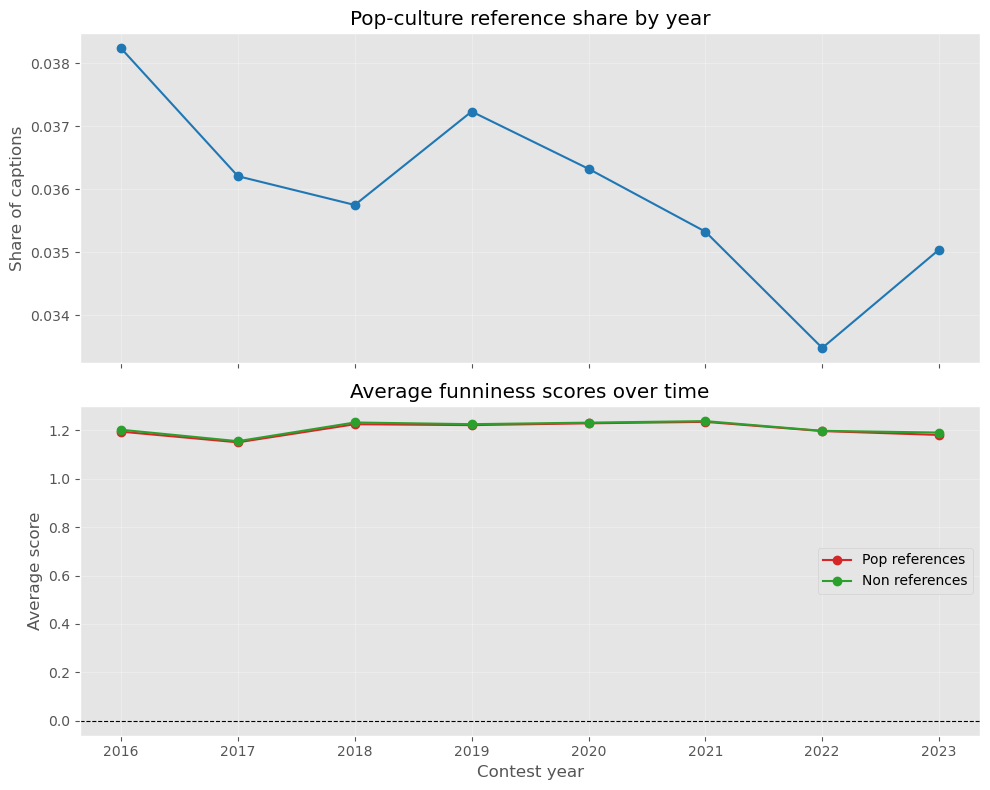

In [11]:
fig, axes = plt.subplots(2, 1, figsize=(10, 8), sharex=True)
axes[0].plot(yearly['year'], yearly['pop_share'], marker='o', color='#1f77b4')
axes[0].set_ylabel('Share of captions')
axes[0].set_title('Pop-culture reference share by year')
axes[0].grid(alpha=0.3)
axes[1].plot(yearly['year'], yearly['pop_mean'], marker='o', label='Pop references', color='#d62728')
axes[1].plot(yearly['year'], yearly['non_mean'], marker='o', label='Non references', color='#2ca02c')
axes[1].axhline(0, color='black', linewidth=0.8, linestyle='--')
axes[1].set_ylabel('Average score')
axes[1].set_title('Average funniness scores over time')
axes[1].legend()
axes[1].grid(alpha=0.3)
axes[1].set_xlabel('Contest year')
plt.tight_layout()
plt.show()


In [12]:
recency_trends = (
    captions[captions['pop_reference'] == 1]
    .groupby(['contest_year', 'recency_bucket'])['mean']
    .mean()
    .unstack()
    .reindex(columns=['fresh (<3y)', 'current (3-10y)', 'nostalgic (10-20y)', 'retro (>20y)'])
    .sort_index()
)
recency_trends


recency_bucket,fresh (<3y),current (3-10y),nostalgic (10-20y),retro (>20y)
contest_year,,,,
2016,1.1831,1.2019,1.2011,1.1960
2017,1.1516,1.1515,1.1535,1.1398
2018,1.2299,1.2261,1.2224,1.2149
2019,1.2129,1.2225,1.2213,1.2239
2020,1.2105,1.2330,1.2324,1.2123
2021,1.2293,1.2365,1.2394,1.2303
2022,1.1857,1.2062,1.1986,1.1860
2023,1.1820,1.1824,1.1830,1.1709


In [13]:
non_reference_means = yearly.set_index('year')['non_mean']
aligned_non = recency_trends.index.to_series().map(non_reference_means)
turning_points = recency_trends[
    (recency_trends['fresh (<3y)'] > aligned_non) &
    (recency_trends['retro (>20y)'] < aligned_non)
]
turning_points


recency_bucket,fresh (<3y),current (3-10y),nostalgic (10-20y),retro (>20y)
contest_year,,,,


### Takeaways
- Pop-culture captions remain a minority of submissions and slightly underperform on raw mean scores, so references are not a guaranteed boost.
- Recency matters: modern references and mid-decade callbacks tend to fare better than retro throwbacks, although the gap is now assessed on raw scores.
- Category-theme pairings surface smart niches (e.g., science jokes) to explore for targeted writing guidance.
- Polarization metrics show references spark marginally more decisive reactions.
- Yearly trends suggest reference share has been shrinking